## **Latihan Model Evaluation**

### **Gunakan dataset 'Titanic'**

**Target: 'alive'**

- Skema pre-processing:
  * Drop feature 'deck'
  * Isi missing value 'age' dengan simple imputer median
  * Isi missing value 'embark town' dengan simple imputer modus
  * One hot encoding: 'sex', 'embark town', 'alone'
  * Ordinal encoding: 'class'
  * Scaling dengan RobustScaler()
<br><br>
- Split data menjadi 80:20 dengan random_state = 0.
- Tentukan metric evaluasi yang sesuai untuk kasus Titanic.
- Pilih model terbaik dengan cross-validation (n_splits=5):
    * Logistic regression: solver = liblinear
    * KNN: n_neighbors = 3
    * Decision tree: max depth = 3
<br>
- Interpretasikan hasil metric yang dipilih tersebut.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics
from sklearn.model_selection import train_test_split

import category_encoders as ce
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, classification_report, f1_score
from sklearn.metrics import roc_curve, roc_auc_score, plot_roc_curve, precision_recall_curve, average_precision_score, plot_precision_recall_curve

import warnings
warnings.filterwarnings('ignore')

In [ ]:
df= pd.read_csv('titanic.csv')
df.head()

,sex,age,parch,fare,class,deck,embark_town,alive,alone
0,male,22.0,0,7.2500,Third,NaN,Southampton,no,False
1,female,38.0,0,71.2833,First,C,Cherbourg,yes,False
2,female,26.0,0,7.9250,Third,NaN,Southampton,yes,True
3,female,35.0,0,53.1000,First,C,Southampton,yes,False
4,male,35.0,0,8.0500,Third,NaN,Southampton,no,True


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   sex          891 non-null    object 
 1   age          714 non-null    float64
 2   parch        891 non-null    int64  
 3   fare         891 non-null    float64
 4   class        891 non-null    object 
 5   deck         203 non-null    object 
 6   embark_town  889 non-null    object 
 7   alive        891 non-null    object 
 8   alone        891 non-null    bool   
dtypes: bool(1), float64(2), int64(1), object(5)
memory usage: 56.7+ KB


In [ ]:
# Drop feature 'deck'
df = df.drop(columns='deck')

## **Define X and y**

In [ ]:
X = df.drop(columns='alive')
y = np.where(df['alive'] == 'yes', 1, 0)

In [ ]:
X.head()

,sex,age,parch,fare,class,embark_town,alone
0,male,22.0,0,7.2500,Third,Southampton,False
1,female,38.0,0,71.2833,First,Cherbourg,False
2,female,26.0,0,7.9250,Third,Southampton,True
3,female,35.0,0,53.1000,First,Southampton,False
4,male,35.0,0,8.0500,Third,Southampton,True


## **Data Splitting**

In [ ]:
X_train, X_test, y_train, y_test= train_test_split(
    X,
    y,
    stratify = y,
    test_size = 0.2,
    random_state = 0)

- https://scikit-learn.org/stable/modules/compose.html#column-transformer
- https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html#sklearn.pipeline.Pipeline

## **Data Transformation**

In [ ]:
# Simple Imputer + Onehot Encoder untuk 'embark_town'
onehot = Pipeline([
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('one hot', OneHotEncoder())
])

# mapping Ordinal Encoder untuk 'class'
mapping = [{'col':'class', 'mapping':{None: 0, 'First':1, 'Second':2, 'Third':3}}]
ordinal = ce.OrdinalEncoder(mapping=mapping)

# Column Transformer
transformer= ColumnTransformer([
    ('One Hot1', onehot, ['embark_town']),
    ('One Hot2', OneHotEncoder(), ['sex', 'alone']),
    ('Ordinal', ordinal,['class']),
    ('Impute', SimpleImputer(strategy='median'), ['age'])
], remainder='passthrough')

In [ ]:
# fit and transform
X_train_preprocessed = pd.DataFrame(transformer.fit_transform(X_train))
X_test_preprocessed = pd.DataFrame(transformer.transform(X_test))

In [ ]:
# Scaling
scaler = RobustScaler()

X_train_prep_scaled = pd.DataFrame(scaler.fit_transform(X_train_preprocessed))
X_test_prep_scaled = pd.DataFrame(scaler.transform(X_test_preprocessed))

X_train_prep_scaled.head()

,0,1,2,3,4,5,6,7,8,9,10
0,0.0,1.0,-1.0,1.0,-1.0,0.0,0.0,0.0,0.000000,0.0,-0.302507
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,-0.283867
2,0.0,1.0,-1.0,1.0,-1.0,0.0,0.0,0.0,0.000000,0.0,-0.297156
3,0.0,0.0,0.0,1.0,-1.0,1.0,-1.0,-2.0,1.769231,0.0,2.812846
4,0.0,1.0,-1.0,0.0,0.0,0.0,0.0,0.0,-0.538462,0.0,-0.297896


## Kalau mau lihat dataframe hasil transformasinya

In [ ]:
X_train_preprocessed.head()

,0,1,2,3,4,5,6,7,8,9,10
0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,3.0,28.0,0.0,7.6292
1,0.0,0.0,1.0,0.0,1.0,0.0,1.0,3.0,28.0,0.0,8.0500
2,0.0,1.0,0.0,1.0,0.0,0.0,1.0,3.0,28.0,0.0,7.7500
3,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,51.0,0.0,77.9583
4,0.0,1.0,0.0,0.0,1.0,0.0,1.0,3.0,21.0,0.0,7.7333


In [ ]:
# kolom 0-2
transformer.transformers_[0][1][1].get_feature_names()

array(['x0_Cherbourg', 'x0_Queenstown', 'x0_Southampton'], dtype=object)

In [ ]:
# kolom 3-6
transformer.transformers_[1][1].get_feature_names()

array(['x0_female', 'x0_male', 'x1_False', 'x1_True'], dtype=object)

In [ ]:
X_train_prep_scaled.rename(columns={
    0:'x0_Cherbourg',
    1:'x0_Queenstown',
    2:'x0_Southampton',
    3:'x0_female',
    4:'x0_male',
    5:'x1_False',
    6:'x1_True',
    7:'class',
    8:'age',
    9:'parch',
    10:'fare'
}, inplace=True)

X_train_prep_scaled.head()

,x0_Cherbourg,x0_Queenstown,x0_Southampton,x0_female,x0_male,x1_False,x1_True,class,age,parch,fare
0,0.0,1.0,-1.0,1.0,-1.0,0.0,0.0,0.0,0.000000,0.0,-0.302507
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,-0.283867
2,0.0,1.0,-1.0,1.0,-1.0,0.0,0.0,0.0,0.000000,0.0,-0.297156
3,0.0,0.0,0.0,1.0,-1.0,1.0,-1.0,-2.0,1.769231,0.0,2.812846
4,0.0,1.0,-1.0,0.0,0.0,0.0,0.0,0.0,-0.538462,0.0,-0.297896


## **Modeling --> Cross Validation**
**Mencari model terbaik untuk melakukan prediksi**

In [ ]:
# Define the models
logreg = LogisticRegression(solver='liblinear')
knn = KNeighborsClassifier(n_neighbors=3)
tree = DecisionTreeClassifier(max_depth=3)

* https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html
* https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html

In [ ]:
# Pilihan model
models = [logreg, knn, tree]

nilai_mean = []
nilai_std = []

# Mencari model terbaik berdasarkan f1 score terbesar dan std terkecil
for i in models:

    skfold = StratifiedKFold(n_splits = 5, random_state = 0)

    model_cv = cross_val_score(
        i,
        X_train_prep_scaled,
        y_train,
        cv = skfold,
        scoring = 'f1'
        )

    nilai_mean.append(model_cv.mean())
    nilai_std.append(model_cv.std())

    print(i , model_cv)

LogisticRegression(solver='liblinear') [0.72222222 0.77777778 0.71153846 0.62745098 0.78632479]
KNeighborsClassifier(n_neighbors=3) [0.75       0.72897196 0.71559633 0.69902913 0.76363636]
DecisionTreeClassifier(max_depth=3) [0.7184466  0.73684211 0.75728155 0.63636364 0.77777778]


In [ ]:
# Perbandingan f1 score dan standard deviation
pd.DataFrame({
    'model': ['logreg','knn','tree'],
    'mean': nilai_mean,
    'std': nilai_std
})

,model,mean,std
0,logreg,0.725063,0.057010
1,knn,0.731447,0.023189
2,tree,0.725342,0.048717


### **Modeling dengan Pipeline**

In [ ]:
# # Pilihan model
# models = [logreg, knn, tree]

# nilai_mean = []
# nilai_std = []

# # Mencari model terbaik berdasarkan f1 score terbesar dan std terkecil
# for i in models:

#     skfold = StratifiedKFold(n_splits = 5, random_state = 0)

#     model_cv = cross_val_score(
#         Pipeline([('prep',transformer), ('scaler',RobustScaler()), ('model', i)]),
#         X_train,
#         y_train,
#         cv = skfold,
#         scoring = 'f1')

#     nilai_mean.append(model_cv.mean())
#     nilai_std.append(model_cv.std())

#     print(i , model_cv)

### **Interpretasi**

- Di antara ketiga model, nilai rata-rata f1 score yang paling tinggi adalah model KNN dengan score 73.1%.
- Model dengan KNN juga menjadi model yang paling stabil karena nilai standar deviasinya paling kecil.
- Oleh karena itu, model KNN dipilih sebagai model terbaik untuk kasus Titanic ini.

## **Modeling --> Prediksi test set**

In [ ]:
# Model performance in test set
knn = KNeighborsClassifier(n_neighbors=3)

# fitting
knn.fit(X_train_prep_scaled, y_train)

KNeighborsClassifier(n_neighbors=3)

* https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html

In [ ]:
# predict
y_pred = knn.predict(X_test_prep_scaled)

# score
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.83      0.81       110
           1       0.71      0.67      0.69        69

    accuracy                           0.77       179
   macro avg       0.75      0.75      0.75       179
weighted avg       0.76      0.77      0.76       179



In [ ]:
# score
print('Precision:', precision_score(y_test, y_pred))
print('Recall:', recall_score(y_test, y_pred))
print('F1 score:', f1_score(y_test, y_pred))

Precision: 0.7076923076923077
Recall: 0.6666666666666666
F1 score: 0.6865671641791045


* https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html

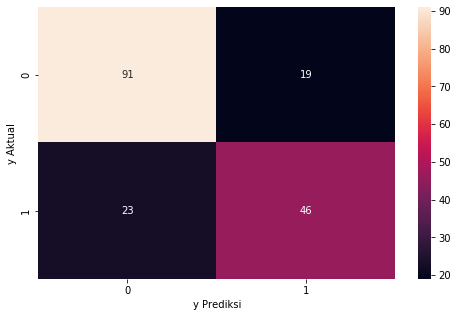

In [ ]:
f, ax = plt.subplots(figsize=(8, 5))

sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='.0f', ax=ax)

plt.xlabel('y Prediksi')
plt.ylabel('y Aktual');

### **Interpretasi**

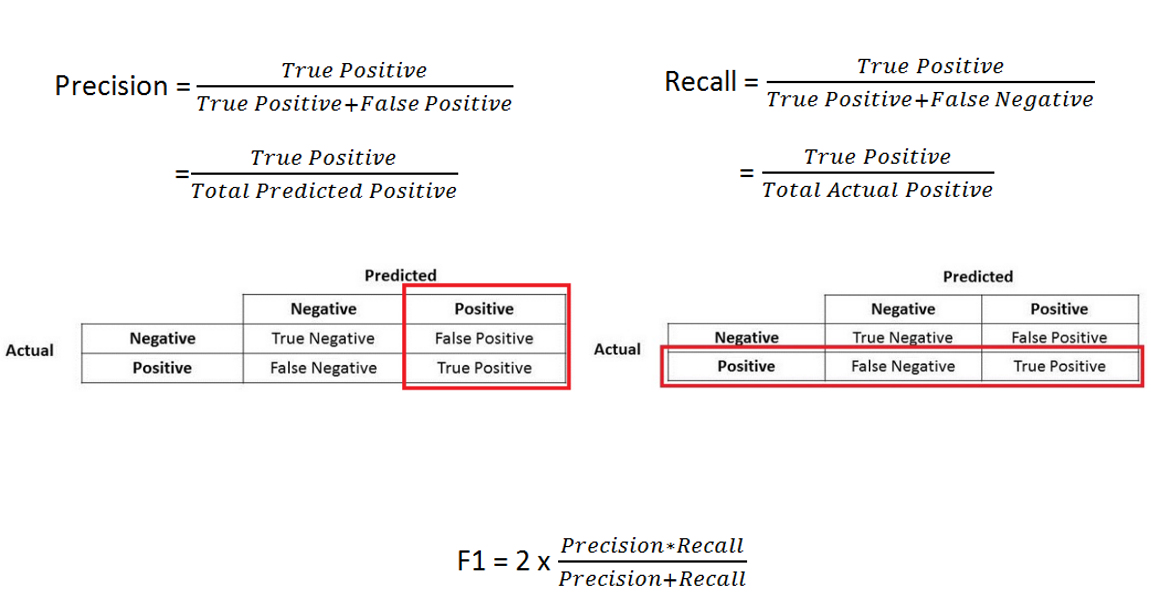

### **Precision**
Precision menggambarkan seberapa akurat model dalam membedakan mana yang aktualnya memang positif dari semua data yang terprediksi positif.

Precision cocok digunakan jika cost untuk False Positive dinilai tinggi. Jika kita menggunakan metric precision, itu berarti kita berusaha untuk meminimalkan jumlah false positive yang dihasilkan oleh model. Namun, perlu selalu diingat bahwa selalu ada trade off antara precision dan recall.

Jadi, dalam kasus Titanic ini, false positive berarti penumpang yang diprediksi survived oleh model, namun aktualnya tidak survived. Dari rumus precision di atas dan dihubungkan dengan kasus Titanic, nilai precision berarti menggambarkan 'dari semua penumpang yang diklasifikasikan sebagai penumpang yang selamat, berapa banyak yang sebenarnya selamat?'

Nilai precision 71% artinya, dari total penumpang yang diklasifikasikan selamat (65 penumpang), 71%-nya berhasil terprediksi dengan benar (46 penumpang).

### **Recall**
Recall menggambarkan berapa banyak jumlah aktual positif yang dapat diprediksi oleh model.

Recall cocok digunakan jika cost untuk False Negative dinilai tinggi. Jika kita menggunakan metric recall, itu berarti kita berusaha untuk meminimalkan jumlah false negative yang dihasilkan oleh model.

Dalam kasus Titanic, false negative berarti penumpang yang diprediksi tidak selamat, namun aktualnya selamat. Itu berarti, nilai recall merepresentasikan 'dari semua penumpang yang selamat, berapa orang yang diklasifikasikan selamat?'

Nilai recall 68% artinya, dari total penumpang yang aslinya selamat (69 orang), 68%-nya berhasil berhasil diprediksi dengan benar (46 penumpang)

### **F1-score**

Pada binary classification, metrik F1-score menggambarkan rata-rata harmonik dari nilai precision dan recall. Nilai F1-score tergantung pada nilai precision dan recall yang didapat. Semakin tinggi nilai precision dan recall, semakin tinggi pula nilai F1-score, dan berlaku sebaliknya.

### **ROC AUC Curve**

ROC = kurva probabilitas

Pada binary classification, ROC AUC curve cocok digunakan ketika kita tertarik pada kedua kelas.

ROC AUC score merepresentasikan score yang didapat dari ROC AUC curve atau dengan kata lain hasil kalkulasi area under the curve. ROC AUC score menggambarkan seberapa baik model dapat membedakan 2 kelas yang ada.

Model classifiers yang memiliki persentase 100% benar dalam prediksinya, akan memiliki ROC AUC score = 1, sedangkan yang terburuk adalah dengan score 0.5 (sama saja dengan random classifier).

In [ ]:
y_proba = knn.predict_proba(X_test_prep_scaled)
y_proba = y_proba[:, 1]

* https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_roc_curve.html

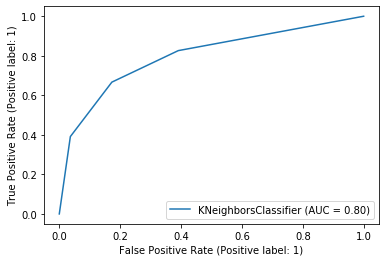

In [ ]:
plot_roc_curve(knn, X_test_prep_scaled, y_test);

Nilai AUC 80% berarti ada kemungkinan 80% model dapat membedakan antar kelas positif dan negatif.

* https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html

In [ ]:
roc_auc_score(y_test, y_proba)

0.798221343873518

* https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_proba, pos_label=1)

In [ ]:
# pd.set_option('display.max_rows', None)

pd.DataFrame({
    'fpr':fpr,
    'tpr':tpr,
    'thresholds':thresholds
})

,fpr,tpr,thresholds
0,0.000000,0.000000,2.000000
1,0.036364,0.391304,1.000000
2,0.172727,0.666667,0.666667
3,0.390909,0.826087,0.333333
4,1.000000,1.000000,0.000000


### **Precision-Recall Curve**

Precision-Recall curve dapat membantu memvisualisasikan bagaimana tiap threshold memengaruhi performa dari model classifier.

Nilai AP yang dihasilkan pada Precision-Recall curve merepresentasikan nilai rata-rata precision dari semua threshold.

* https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_precision_recall_curve.html

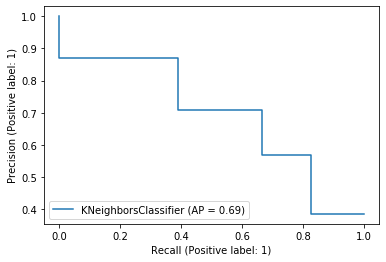

In [ ]:
plot_precision_recall_curve(knn, X_test_prep_scaled, y_test);

* https://scikit-learn.org/stable/modules/generated/sklearn.metrics.average_precision_score.html
* https://scikit-learn.org/stable/modules/model_evaluation.html#precision-recall-f-measure-metrics

In [ ]:
average_precision_score(y_test, y_proba)

0.6935939304700618

* https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_curve.html

In [ ]:
p, r, th = precision_recall_curve(y_test, y_proba)

In [ ]:
th = list(th)
th.insert(0, 0)

In [ ]:
th

[0, 0.0, 0.3333333333333333, 0.6666666666666666, 1.0]

In [ ]:
pd.DataFrame({
    'recall':r,
    'precision':p,
    'threshold':th
})

,recall,precision,threshold
0,1.000000,0.385475,0.000000
1,0.826087,0.570000,0.000000
2,0.666667,0.707692,0.333333
3,0.391304,0.870968,0.666667
4,0.000000,1.000000,1.000000


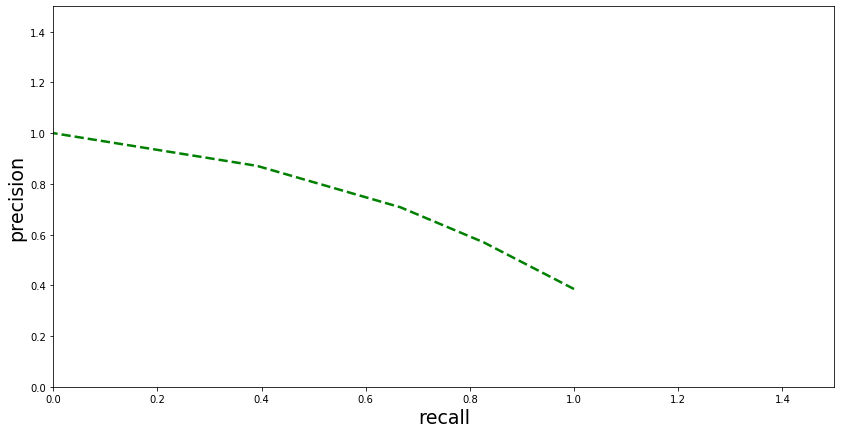

In [ ]:
def plot_precision_vs_recall(precision, recall):
    plt.plot(recall, precision, 'g--', linewidth=2.5)
    plt.xlabel('recall', fontsize=19)
    plt.ylabel('precision', fontsize=19)
    plt.axis([0, 1.5, 0, 1.5])

plt.figure(figsize=(14, 7))
plot_precision_vs_recall(p, r)
plt.show()

## **Latihan Hyperparameter Tuning**<br>
### **Gunakan dataset 'insurance'**

Carilah model dan hyperparameter terbaik untuk memprediksi biaya asuransi tiap individu berdasarkan karakteristiknya.
1. Lakukan EDA singkat untuk mengeksplorasi dataset terlebih dahulu.
2. Lakukan preprocessing pada features jika dibutuhkan.
3. Lakukan modeling dengan menggunakan linear regression, knn regressor, dan decision tree regressor.<br>
    Kandidat algoritma:
    - linreg = LinearRegression(fit_intercept=True)
    - knn = KNeighborsRegressor(n_neighbors=5)
    - tree = DecisionTreeRegressor(criterion='mae', min_samples_leaf=1, max_depth=5, random_state=0)
4. Pilih 1 model terbaik berdasarkan hasil cross validasi 3 model di atas.
5. Lakukan prediksi pada test set dari model terpilih (sebelum hyperparameter tuning).
6. Lakukan hyperparameter tuning pada model terpilih tsb.
7. Lakukan prediksi pada test set dari model dengan hyperparameter tuning.
8. Bandingkan hasil performa model sebelum dan sesudah tuning.

*Tips: Gunakan Pipeline*<br>
### **Features Description**

- age: age of primary beneficiary

- sex: insurance contractor gender, female, male

- bmi: Body mass index, providing an understanding of body, weights that are relatively high or low relative to height,
objective index of body weight (kg / m ^ 2) using the ratio of height to weight, ideally 18.5 to 24.9

- children: Number of children covered by health insurance / Number of dependents

- smoker: Smoking

- region: the beneficiary's residential area in the US, northeast, southeast, southwest, northwest.

- charges: Individual medical costs billed by health insurance